# Numerical Gradients

First we will get things rocking and rolling with Cody's old data at h11=15.

In [4]:
import matplotlib as mpl

mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
fsize = 20
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

def _validate_distribution(values, weights):
    # Validate the value array.
    values = np.asarray(values, dtype=float)
    if len(values) == 0:
        raise ValueError("Distribution can't be empty.")

    # Validate the weight array, if specified.
    if weights is not None:
        weights = np.asarray(weights, dtype=float)
        if len(weights) != len(values):
            raise ValueError('Value and weight array-likes for the same '
                             'empirical distribution must be of the same size.')
        if np.any(weights < 0):
            raise ValueError('All weights must be non-negative.')
        if not 0 < np.sum(weights) < np.inf:
            raise ValueError('Weight array-like sum must be positive and '
                             'finite. Set as None for an equal distribution of '
                             'weight.')

        return values, weights

    return values, None

def _cdf(p, u_values, v_values, u_weights=None, v_weights=None):
    #print "input", u_values, v_values
    u_values, u_weights = _validate_distribution(u_values, u_weights)
    v_values, v_weights = _validate_distribution(v_values, v_weights)

    u_sorter = np.argsort(u_values)
    v_sorter = np.argsort(v_values)

    all_values = np.concatenate((u_values, v_values))
    all_values.sort(kind='mergesort')
    #print 'av', all_values

    # Compute the differences between pairs of successive values of u and v.
    deltas = np.diff(all_values)

    # Get the respective positions of the values of u and v among the values of
    # both distributions.
    u_cdf_indices = u_values[u_sorter].searchsorted(all_values[:-1])#, 'right')
    v_cdf_indices = v_values[v_sorter].searchsorted(all_values[:-1])#, 'right')
    #print 'ucdfind', u_cdf_indices

    # Calculate the CDFs of u and v using their weights, if specified.
    if u_weights is None:
        u_cdf = u_cdf_indices / 1.0 / u_values.size
    else:
        u_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(u_weights[u_sorter])))
        u_cdf = u_sorted_cumweights[u_cdf_indices] / u_sorted_cumweights[-1]

    if v_weights is None:
        v_cdf = v_cdf_indices / 1.0 / v_values.size
    else:
        v_sorted_cumweights = np.concatenate(([0],
                                              np.cumsum(v_weights[v_sorter])))
        v_cdf = v_sorted_cumweights[v_cdf_indices] / v_sorted_cumweights[-1]


    #print 'uv', u_cdf, v_cdf, u_values.size

    # Compute the value of the integral based on the CDFs.
    # If p = 1 or p = 2, we avoid using np.power, which introduces an overhead
    # of about 15%.

    #print 'check1', deltas

    return np.sum(np.multiply(np.abs(u_cdf - v_cdf), deltas))

def wasserstein_distance(u_values, v_values, u_weights=None, v_weights=None):
    return _cdf(1, u_values, v_values, u_weights, v_weights)

In [5]:
import numpy as np
#from scipy.stats import wasserstein_distance
import seaborn as sns
from matplotlib import pyplot as plt
import math

real_eigs_cody = np.loadtxt("ppo2/h11=15.txt")

def initial_vars(nmod):
    littlevars = [1./np.float(nmod)**(1./2.) for i in range(nmod + 1)]
    vars = []
    for ii in range(nmod + 1):
        vars = vars + littlevars
    return vars

def random_bergman_2(nmod,vars=None): # pos def metric
    if vars == None:
        vars = initial_vars(nmod)

    A = []
    for rowind in range(nmod + 1):
        A.append([np.random.normal(loc = 0, scale = vars[pp]) for pp in range(rowind*(nmod + 1), (rowind+1)*(nmod + 1))])
    A = np.array(A)
    P = np.dot(A.transpose(),A)
    P00 = P[0][0]
    P0a = [P[0][a] for a in range(1,nmod+1)]
    Pab = [[P[a][b] for a in range(1,nmod+1)] for b in range(1,nmod + 1)]
    m = Pab/P00 - [[P0a[i]*P0a[j] for i in range(len(P0a))] for j in range(len(P0a))]/P00**2
    
    return m

random_bergman_2(10)

def sample(nmod,numdraws, vars = None):
    if vars == None:
        vars = initial_vars(nmod)
    evals = []
    for num in range(numdraws):
        evals  = evals + list(np.linalg.eig(random_bergman_2(nmod,vars=vars))[0])
    return evals

def wasserstein_loss(vars, numdraws=30, numspectra=1, real_eigs = real_eigs_cody): # h11 = len(vars)-2
    return np.mean([wasserstein_distance(sample(h11_func(len(vars)),numdraws,vars=vars),real_eigs) for i in range(numspectra)])
               
def bounded_update(vec,shift_vec): # rescales so that no entry in vec goes below zero
    pow = 1
    new_vec = [vec[i]- shift_vec[i] / pow for i in range(len(vec))]
    while [i < 0 for i in new_vec].count(1) > 0: # has negative
        pow += 1
        new_vec = [vec[i]- shift_vec[i] / pow for i in range(len(vec))]
    return new_vec, pow 
    
def h11_func(lenvars):
    return int(math.sqrt(lenvars)-1)
    
def numerical_gradient(vars, gradwidth = .001, normalize=False):
    h11 = h11_func(len(vars))
    gradwidth = np.float((gradwidth))*1./np.float(h11)**(1./2.)
    
    grad = [0.0 for i in range(len(vars))]
    for i in range(len(vars)):
        
        #stepup, stepdown = vars[0:], vars[0:]
        #stepup[i] += gradwidth
        #stepdown[i] += -gradwidth
        stepup, powup = bounded_update(vars,[-gradwidth if j == i else 0 for j in range(len(vars))])
        stepdown, powdown = bounded_update(vars,[gradwidth if j == i else 0 for j in range(len(vars))])
        grad[i] = (wasserstein_loss(stepup)-wasserstein_loss(stepdown))/(powup+powdown)/gradwidth
    
    if normalize:
        norm = np.linalg.norm(grad) 
        return [k/norm for k in grad]
    else: return grad

def gradient_descent(vars, num_iter=1000, gradwidth = .001, lr = .001, logplot = True, real_eigs = real_eigs_cody):
        
    loss, numsteps = 1e6, 0
    best = ([],loss)
    
    for _ in range(num_iter): 
        grad = numerical_gradient(vars, gradwidth = gradwidth)
        vars, _ = bounded_update(vars,[lr*g/(10-loss) for g in grad])
        #print grad
        #print vars
        loss = wasserstein_loss(vars, real_eigs = real_eigs)
        
        # prints and trivial  updates
        if loss < best[1]:
            best = (vars,loss)
            print "new best:", loss
            print "state:", vars
            if logplot:
                sns.distplot([np.log10(k) for k in real_eigs], kde=False, label='10', norm_hist = True)
                sns.distplot([np.log10(k) for k in sample(h11_func(len(vars)),300,vars=vars)], kde=False, label='10', norm_hist = True)
            else:
                sns.distplot([k for k in real_eigs], kde=False, label='10', norm_hist = True)
                sns.distplot([k for k in sample(h11_func(len(vars)),300,vars=vars)], kde=False, label='10', norm_hist = True)
            
            plt.show()
        if numsteps % 10 == 0: print "steps: {} \t loss: {}".format(numsteps,loss)
        numsteps += 1

In [ ]:
import os
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import torch
import models.dcgan as dcgan
import torchvision
from torchvision.utils import make_grid
from scipy.stats import wasserstein_distance

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:800% !important; }</style>"))

def batch_upper_left(tensor,m): # in: (batch_size,1,n,n) out: upper left (batch_size, 1, m, m)
    return torch.Tensor.narrow(torch.Tensor.narrow(tensor,3,0,m),2,0,m)

def histogram(df_column, label, kde = False, norm_hist = True, show = True, log10 = True):
    if log10:
        df_column = np.log10(df_column)
        df_column = df_column.replace([np.inf, -np.inf], np.nan)
        df_column = df_column.dropna()
        plot = sns.distplot(df_column, kde = kde, norm_hist = norm_hist, label = label)
    else:
        plot = sns.distplot(df_column, kde = kde, norm_hist = norm_hist, label = label)
    if show:     
        plt.show()
    return plot

def histograms(df_columns, labels, kde = False, norm_hist = True, show_together = True, show_separate = False, log10 = True):
    from matplotlib import rcParams
    rcParams['figure.figsize'] = 11.7,8.27
    plt.legend(prop={'size':12})
    for idx, df_column in enumerate(df_columns): 
        histogram(df_column, labels[idx], kde = kde, norm_hist = norm_hist, show = show_separate, log10 = log10)
    if show_together: 
        plt.show()

# isize: imageSize, nz: size of latent z vector,ng
def load_DCGAN(filepath, nz=100, nc=1, ngf=64, ngpu=0, n_extra_layers=0):
    h11 = int(filepath.split('/')[1].split('_')[2])
    epoch = int(filepath.split('/')[-1].split('_')[-1].split('.')[0])
    isize = (h11-h11%16)+16
    netG = dcgan.DCGAN_G(isize, nz=nz, nc=nc, ngf=ngf, ngpu=ngpu, n_extra_layers=n_extra_layers)
    dcgan.DCGAN_G.load_state_dict(netG,torch.load(filepath, map_location='cpu'))
    return (h11,epoch,netG)

def gen_matrices(GAN, noise = None, batchSize = 64, nz = 100):
    if type(noise) == type(None):
        noise = torch.FloatTensor(batchSize, nz, 1, 1)
        noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
    return GAN(noise)

def gen_wishart_matrices(h11, batchSize = 64):
    A = torch.randn(batchSize,h11,h11)
    AT = torch.transpose(A,1,2)
    return torch.bmm(AT,A)/torch.tensor(1.0*h11)

def ensemble_eigenvalues(data_tensor): # data_tensor is batch of matrices
    eigs = []
    for matrix in data_tensor:
        img_size = matrix.shape[1]
        matrix = matrix.view(img_size,img_size).detach().numpy()
        eigs.extend(np.linalg.eig(matrix)[0])
    return eigs

def show_images(tensor, nrow=8, padding=2,
               normalize=False, range=None, scale_each=False, pad_value=0):
    tensor.data = tensor.data.mul(0.5).add(0.5)
    img = torchvision.utils.make_grid(tensor, nrow=nrow, padding=padding, pad_value=pad_value,
                     normalize=normalize, range=range, scale_each=scale_each)
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()
    
def show_GAN_image_sequence(GANlist, batchSize = 64, nz = 100):
    fixed_noise = torch.FloatTensor(batchSize, nz, 1, 1)
    fixed_noise.resize_(batchSize, nz, 1, 1).normal_(0, 1)
    for h11, epoch, GAN in GANlist:
        print "(h11, epoch):", (h11,epoch)
        show_images(gen_matrices(GAN, noise = fixed_noise, nz=nz))
        
def show_GAN_histogram(GAN, h11, nz = 100, noise = None, inverse_wishart = False, batchSize = 10000, kde = False, display_wishart = True, norm_hist = True, show = True, log10 = True):
    data_tensor = gen_matrices(GAN, noise = noise, batchSize = batchSize, nz = nz)
    data_tensor = batch_upper_left(data_tensor, h11)
    eigs = ensemble_eigenvalues(data_tensor)
    wishart_eigs = ensemble_eigenvalues(gen_wishart_matrices(h11,batchSize))
    if inverse_wishart:
        wishart_eigs = [1/k for k in wishart_eigs]
    
    log_eigs, log_wishart_eigs, log_real_eigs = [k for k in np.log10(eigs) if k not in [np.nan, np.inf, -np.inf]], [k for k in np.log10(wishart_eigs) if k not in [np.nan, np.inf, -np.inf]], [k for k in np.log10(np.array(real_eig_dfs[h11])) if k not in [np.nan, np.inf, -np.inf]]
    print "Wasserstein Distance GAN (no log, log):", wasserstein_distance(eigs,real_eig_dfs[h11]), wasserstein_distance(log_eigs, log_real_eigs)
    print "Wasserstein Distance Wishart (no log, log):", wasserstein_distance(wishart_eigs,real_eig_dfs[h11]), wasserstein_distance(log_wishart_eigs, log_real_eigs)
    
    histogram(real_eig_dfs[h11], str(h11), show = False, log10 = log10)
    if display_wishart:
        histogram(pd.DataFrame({h11: wishart_eigs})[h11], label=str(h11), kde = kde, norm_hist = norm_hist, show = False, log10 = log10)
    histogram(pd.DataFrame({h11: eigs})[h11], label=str(h11), kde = kde, norm_hist = norm_hist, show = show, log10 = log10)
    
    return wasserstein_distance(eigs,real_eig_dfs[h11]), wasserstein_distance(wishart_eigs,real_eig_dfs[h11]), wasserstein_distance(log_eigs,log_real_eigs)

new best: 7.662329710192542
state: [0.2581988919549483, 0.25819889122239686, 0.2581988894707896, 0.25819889135297774, 0.2581988917889336, 0.2581988899048346, 0.258198890045299, 0.2581988891553268, 0.25819888891880666, 0.25819888676726854, 0.25819888878307173, 0.25819889036304167, 0.25819888983229133, 0.25819888981778255, 0.25819889079144853, 0.2581988927862994, 0.2581988902828486, 0.25819888833204707, 0.2581988884809448, 0.25819889300303717, 0.2581988893668802, 0.2581988922205318, 0.2581988918013783, 0.2581988930117676, 0.25819889059643325, 0.2581988857056761, 0.2581988927360838, 0.25819888781821465, 0.25819888893918824, 0.2581988908556454, 0.2581988892937152, 0.2581988900622785, 0.2581988935660821, 0.2581988888968322, 0.25819889008665114, 0.2581988883145253, 0.2581988875231483, 0.2581988883113909, 0.25819889110678024, 0.2581988876382356, 0.25819888878664643, 0.25819888824125287, 0.25819889075542507, 0.25819889051775796, 0.2581988927390578, 0.25819889436559373, 0.25819888707682226, 0.2

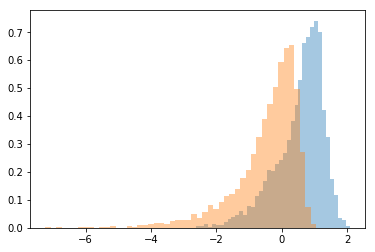

steps: 0 	 loss: 7.66232971019
new best: 7.526545008715846
state: [0.2565630440383629, 0.2591310686730631, 0.2579059816558344, 0.25752234286559184, 0.25714108463260804, 0.259081227807454, 0.25896910968229103, 0.2572882529667416, 0.2595225303836258, 0.25769362013102143, 0.25616455336897925, 0.25766524027446114, 0.25914256315716616, 0.2572341139513299, 0.2576242304663669, 0.2576919722651325, 0.25772245397370974, 0.25956018701670724, 0.2569337166518426, 0.2577260784714961, 0.2569972173287309, 0.25866369972031694, 0.2570524131210559, 0.25813577138825805, 0.2582583765738334, 0.25767773291049856, 0.25972708797326993, 0.25655793495930596, 0.25853386018350105, 0.2568201515526767, 0.25940902673779775, 0.2579433477126058, 0.25818971242298333, 0.2586925370894603, 0.25847779866553444, 0.25840328674685825, 0.25826632699777874, 0.25903203910198064, 0.25929631728703195, 0.25893199337952866, 0.25798531894723437, 0.258350846548125, 0.259423500756951, 0.2594080635778832, 0.25814570582862434, 0.257011554

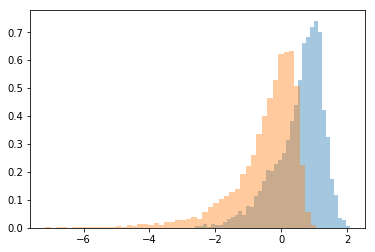

new best: 7.500060887784748
state: [0.25607206516983394, 0.2598026957048425, 0.2563988547559978, 0.2612203788607415, 0.2606046801164497, 0.2611100176917382, 0.2586470221786145, 0.25650312995310814, 0.259984072026616, 0.25810128944938826, 0.2570454955190425, 0.2576857679025247, 0.2601295168240403, 0.2576694416845967, 0.2565738147190519, 0.25661826359601064, 0.2546724347773935, 0.26138397149420634, 0.2555307771218636, 0.25674862874060267, 0.25472612930359134, 0.2600881859220392, 0.25809725002024814, 0.25239344558866594, 0.25639321809255156, 0.25636538773589196, 0.256359937070466, 0.259458094663218, 0.25771713111780165, 0.25396791681588243, 0.25608325946261706, 0.25410732589769836, 0.2580065888607422, 0.2628035457892799, 0.25713297692641035, 0.2551033393385698, 0.2611230842710053, 0.2609528991035865, 0.25993744798773993, 0.2570521516294339, 0.25970132456622286, 0.2572928562400916, 0.2591121598574542, 0.2599206359327571, 0.259281323463125, 0.2552111206749756, 0.2550699391693847, 0.25907368

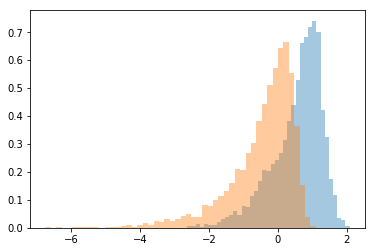

new best: 7.49821789089542
state: [0.25557637203296674, 0.2593849512128522, 0.2557174847564896, 0.26056882985622426, 0.2622545782566914, 0.2619635843613681, 0.2589221467802049, 0.2554202016725823, 0.26044904179408807, 0.25769941031169513, 0.2572447186392477, 0.2575143111496689, 0.25981849514289923, 0.25802633306728007, 0.2566585774964071, 0.2576517392186636, 0.2544978357796605, 0.26158772343053727, 0.25567264821828983, 0.25644277361410195, 0.2549430053300912, 0.26254373786150803, 0.2581733493795418, 0.2520139657015945, 0.25666843783035603, 0.2558293365285017, 0.2544072275507465, 0.26047466668639235, 0.2584105648833621, 0.25510490937227703, 0.2563340257945778, 0.2545431030073308, 0.25836152660103584, 0.2636641734892866, 0.2571917185914992, 0.2558066777044908, 0.26156062680285563, 0.2597023371189865, 0.25956423727642197, 0.2567968956073353, 0.26060563800972675, 0.2575686979708366, 0.2607910840474475, 0.25909521061675356, 0.25833632401651613, 0.25395389749297054, 0.2553631875482183, 0.260

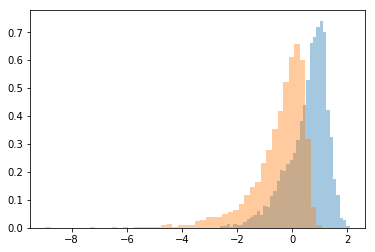

new best: 7.3751361301111675
state: [0.2541335607605772, 0.25976619597772005, 0.25368944920466263, 0.2582322246530282, 0.26178131580049074, 0.2612912891654357, 0.25851481226063316, 0.2548547253791571, 0.2578986421451928, 0.25681055133495834, 0.25759905295560276, 0.2586093893300173, 0.26026913012143743, 0.2590360517966476, 0.258202852174739, 0.2574291610179491, 0.25517070944116405, 0.26242885092043156, 0.2552597485157909, 0.25704367499926517, 0.25490159366263154, 0.2607352377400579, 0.25756243223584063, 0.2532028924963575, 0.25826295717237346, 0.25409264763122047, 0.25349122743594493, 0.2609933768481646, 0.2580815438500366, 0.25543957818027013, 0.2547708444287688, 0.25629364902230367, 0.2568952171271577, 0.26655754419886, 0.2587914459653088, 0.255656759141468, 0.2598316503322487, 0.26223741771063114, 0.260363538791853, 0.2564882652474097, 0.2618363700233763, 0.2579759945631565, 0.258878880418069, 0.26088735119008105, 0.26021805612889126, 0.2542851787674602, 0.2564330915821379, 0.2591251

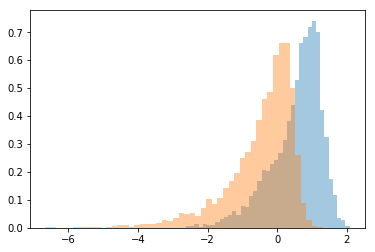

steps: 10 	 loss: 7.45728575875
steps: 20 	 loss: 7.59718480208
steps: 30 	 loss: 7.65001387694
new best: 7.368295700713204
state: [0.25292571468198494, 0.2595818617710845, 0.24941172295426658, 0.25837617975043636, 0.2647803437048252, 0.2605951017670604, 0.26397638595658285, 0.2562946638419524, 0.24952301144990943, 0.25814289058316875, 0.25010222838050805, 0.26776507461393, 0.26244535200694363, 0.2606946927223561, 0.2585731625700385, 0.25973213075893714, 0.26015377381872357, 0.2666873561935431, 0.2482892681439607, 0.26328148201828755, 0.26358852548638584, 0.2635956624096476, 0.25377303734417844, 0.2524054729062299, 0.25328976835598843, 0.2528497373223574, 0.2556945948544833, 0.2608767042537029, 0.2536444891212216, 0.25471861027312753, 0.25620080115090466, 0.2570883715719512, 0.2585204988687555, 0.26859973066159004, 0.25743175269973984, 0.26253763265683044, 0.25062851262024227, 0.260372402232403, 0.2674664722133301, 0.2555006657153302, 0.2643676084333833, 0.2572484715768901, 0.262224622

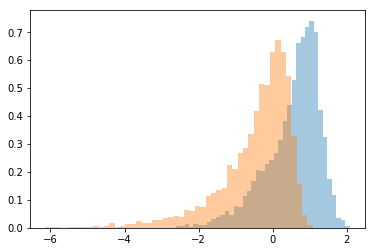

steps: 40 	 loss: 7.54505636348


KeyboardInterrupt: 

In [6]:
gradient_descent(initial_vars(15), gradwidth=.01, lr=.0001)    

new best: 7.523787401556098
state: [0.31622773816380456, 0.31622777270856817, 0.3162277746839783, 0.316227751572329, 0.3162277826864221, 0.3162277725769799, 0.31622777330653984, 0.31622772714755115, 0.31622775961539457, 0.3162277797382642, 0.31622777401925395, 0.31622777511494077, 0.31622773383736635, 0.31622778419849906, 0.3162277795170759, 0.316227772659715, 0.316227751211663, 0.31622775658822583, 0.31622773195725623, 0.316227785535089, 0.3162277780793213, 0.31622776726825275, 0.3162277297562841, 0.3162278170738391, 0.31622776568727373, 0.3162277876268206, 0.3162277509169499, 0.3162278008882697, 0.3162277384862571, 0.3162277774980322, 0.31622773100217905, 0.3162277963471051, 0.31622774087700617, 0.3162277949895882, 0.316227779596783, 0.3162277235522769, 0.31622773155646033, 0.31622779438768184, 0.3162277894540744, 0.3162277669823482, 0.3162277602280536, 0.31622779460002626, 0.3162277360849815, 0.3162277313305095, 0.31622775670655556, 0.31622782947533934, 0.31622779962976244, 0.316227

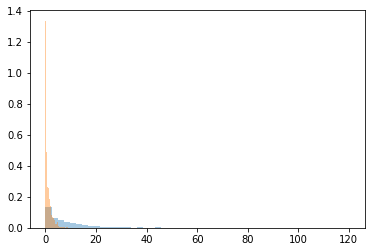

steps: 0 	 loss: 7.52378740156
new best: 7.513237611799935
state: [0.32877618374079887, 0.30974707652647976, 0.32828508199834117, 0.3083536041724528, 0.29256577918386206, 0.30545272804329054, 0.30862526808348817, 0.3375581039385159, 0.3034085924465301, 0.3093656572146118, 0.2882650580995511, 0.2977131101824393, 0.30607987562910977, 0.32652969868334414, 0.3173596652912943, 0.3022933801514009, 0.29849914517650994, 0.29929182123037745, 0.2871841148097517, 0.32176948009560974, 0.33742688469417903, 0.330816316170849, 0.30373863380313476, 0.31332622955075995, 0.30166803777026463, 0.30306700888623, 0.3106251465760547, 0.3328129238047871, 0.2986409079353003, 0.29446538376815307, 0.35179390437369934, 0.3184519524706053, 0.33343396854371365, 0.3240668422164852, 0.3048175526494105, 0.3105789164107829, 0.30679530029938884, 0.2952622797512029, 0.3177243856953641, 0.3605831863022979, 0.3338630634857088, 0.31021999700817865, 0.2808072676370865, 0.34858097701801155, 0.31079045797882926, 0.339977365354

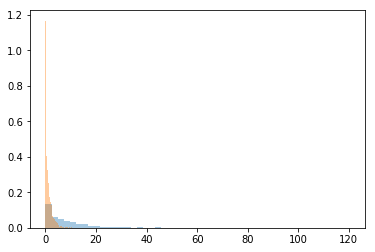

new best: 7.467417771802321
state: [0.329135440381122, 0.31670065046480084, 0.33781419507447047, 0.3232002420673403, 0.2904658575985649, 0.2807906336179848, 0.31263799298220923, 0.3339767175267077, 0.3247558119821901, 0.30598422585795965, 0.32243271633342074, 0.3142555998921991, 0.3124657662960569, 0.3281563006426583, 0.3278337748476531, 0.3007567986599747, 0.3008566816963404, 0.2973070521168185, 0.3095869503596402, 0.33304731763784806, 0.3435476562355923, 0.3332413908154322, 0.3015505749035785, 0.31338522144850184, 0.3059803460538057, 0.3118455049145963, 0.3294788413470305, 0.3288598499359822, 0.2955244427686442, 0.2983013507830889, 0.3430671247917422, 0.34112061157775075, 0.330926001495725, 0.3127535960860727, 0.3022115503208981, 0.3128353037358394, 0.3186151350935152, 0.3101560652836209, 0.2897316987419555, 0.34317389208273297, 0.33707142473840174, 0.3063646335913866, 0.2709341151281469, 0.34995286927838515, 0.32544112615345394, 0.33586543444187766, 0.3308564360986744, 0.31776451645

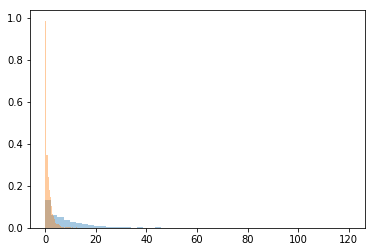

new best: 7.417705697629545
state: [0.32016920189370274, 0.2925909384178005, 0.3153297936712653, 0.3490080935620704, 0.27670359546614137, 0.2631935428551578, 0.3432202243473572, 0.32253825439392214, 0.34537269944118515, 0.29014622389394323, 0.35079171809330145, 0.33511991899957183, 0.3173519033771929, 0.30065045833532655, 0.33132401811135537, 0.28664207867375907, 0.26377685924676264, 0.28621663037164646, 0.2875252399403995, 0.31862760314187544, 0.3631878524829015, 0.33041771699965794, 0.2876819568229181, 0.33052097259517454, 0.29093616306404835, 0.27821232754510117, 0.3498187628602011, 0.30627393169938416, 0.3091656201914652, 0.2918882734998816, 0.35094970306934825, 0.31625412584044077, 0.34558747910431836, 0.3443515912589117, 0.31397859347917073, 0.3165245582156329, 0.2991375319083136, 0.2764138167477708, 0.3205509868856405, 0.33096309870060636, 0.31256431251152694, 0.2962429579965656, 0.28632036553490664, 0.39043444971527946, 0.292509409722946, 0.3195468038064394, 0.3785125649007527,

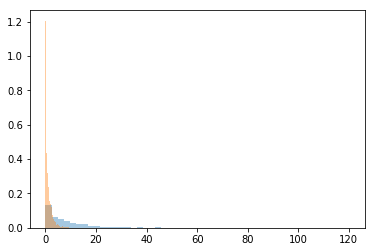

steps: 10 	 loss: 7.58269794061
new best: 7.373943835985324
state: [0.36195009180476795, 0.2738577961154128, 0.3207445290865828, 0.33755804845748033, 0.26423932898093117, 0.22650706120159497, 0.33140741485863223, 0.3283769999282959, 0.3484402419109854, 0.2939887324724342, 0.34152417041266847, 0.3320109715677996, 0.2780802573379652, 0.3105104097374475, 0.345291611237824, 0.28460967770017254, 0.24163445574791328, 0.34432743405784183, 0.2830340650498707, 0.33779844454393304, 0.4101470966981677, 0.3296918607923894, 0.3031368089819962, 0.35367188709241426, 0.2899484711138861, 0.28927383569015047, 0.33659205406760456, 0.3110524647937728, 0.30432649536734246, 0.3218421437418607, 0.3877056232727465, 0.32965426782177454, 0.34098621166962206, 0.358955246493439, 0.27044098073359335, 0.3995078778292344, 0.2701770432066098, 0.2835357896553439, 0.33177676252013566, 0.308934112312679, 0.3058970387446257, 0.30308433641568794, 0.28552090852575585, 0.3702867504455139, 0.2683972026575105, 0.3094229414068

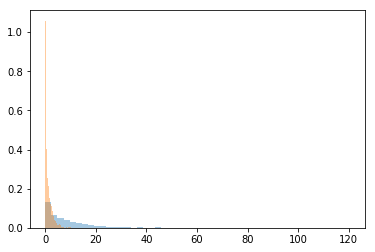

steps: 20 	 loss: 7.57464374473
steps: 30 	 loss: 7.57418721611
new best: 7.093698640303372
state: [0.3010775923307104, 0.3766083981590338, 0.419034857641234, 0.3289906761514104, 0.2862276545489523, 0.27341226253730533, 0.29676428177633685, 0.2974695880445446, 0.4024162612370671, 0.32177855747228884, 0.32652099530781237, 0.3217610294255936, 0.26736718937501003, 0.26626443523572424, 0.3743969440950528, 0.22270821882858888, 0.2602434800586602, 0.3375897441826742, 0.23802038657519178, 0.35790012052529585, 0.416428578870378, 0.33582223741356126, 0.30423402003145245, 0.23424680382102156, 0.2183090918470487, 0.3255039483442148, 0.349077477996532, 0.3206892378989135, 0.33612244668903724, 0.345290873567065, 0.3365792431483512, 0.32608857243311357, 0.36328983493337924, 0.3525171785888356, 0.2863280781568498, 0.3262606459342859, 0.2854932697752963, 0.2670246389246882, 0.3032203147466966, 0.35659209185752294, 0.3156340487460466, 0.3213587263537335, 0.2825961324058405, 0.351674007886439, 0.2792552

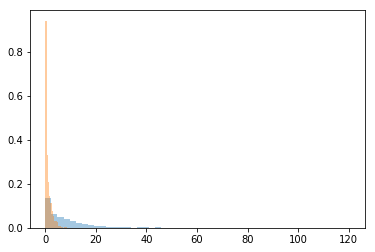

steps: 40 	 loss: 7.51001005331
steps: 50 	 loss: 7.62289703574
steps: 60 	 loss: 7.47935794806
new best: 6.831509770566042
state: [0.24858814211397212, 0.4012163035981394, 0.40447783672042437, 0.4272777930716763, 0.31942737751415134, 0.23961430022636557, 0.2950982141181568, 0.4121455731307436, 0.4527911062535089, 0.3090054061991975, 0.38133432017518676, 0.20292035125872485, 0.25637656546975296, 0.16983973548077633, 0.3349154192495461, 0.24184503803403126, 0.1730618227429814, 0.3219557926120833, 0.2701700660404163, 0.3903949668857517, 0.4250301171706573, 0.2210696283679487, 0.3058581099813848, 0.21054322318355856, 0.2054662644248097, 0.41478318884655546, 0.3541681074214948, 0.40882861117269637, 0.347171059029039, 0.3582349660581158, 0.3578266288082677, 0.32250399056177304, 0.4327402133721034, 0.33991765833179066, 0.3558050341361021, 0.3356002380624811, 0.3196113109311407, 0.27815492830267474, 0.18643840086047245, 0.4251043092027477, 0.29968765108110246, 0.4478624588053408, 0.2970123209

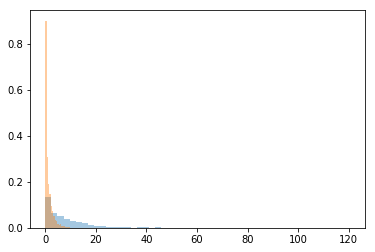

steps: 70 	 loss: 7.43052826478
steps: 80 	 loss: 7.38661829838
steps: 90 	 loss: 7.41237605782
steps: 100 	 loss: 7.40070017592
steps: 110 	 loss: 7.55575974288
steps: 120 	 loss: 7.41025576782


In [ ]:
gradient_descent(initial_vars(10), gradwidth=.01, lr=.001, logplot = False)  

# Systematic Calabi-Yau Data

In [3]:
CY_eigs = {
          10: np.loadtxt("KS4/h11_10_eigs.txt"),
          20: np.loadtxt("KS4/h11_20_eigs.txt"),
          30: np.loadtxt("KS4/h11_30_eigs.txt"),
          40: np.loadtxt("KS4/h11_40_eigs.txt"),
          50: np.loadtxt("KS4/h11_50_eigs.txt")
          }

new best: 9.335351902812436
state: [0.31622776530079577, 0.3162277671412899, 0.3162277665859924, 0.3162277658712597, 0.3162277698485485, 0.3162277681510991, 0.3162277656185072, 0.3162277663320683, 0.31622776673935127, 0.3162277666835251, 0.31622776270114095, 0.316227765958139]


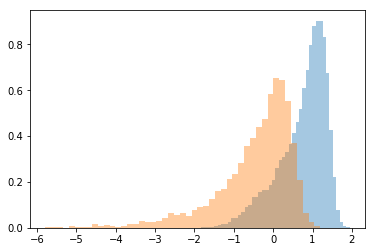

steps: 0 	 loss: 9.33535190281
new best: 9.246523789654987
state: [0.3135309783353648, 0.31684398627376226, 0.3092794884234034, 0.3124100718454809, 0.3206191113870368, 0.3194175796396043, 0.31358808376458464, 0.32039151593919873, 0.31845963015076556, 0.3196396742802555, 0.3143582874061477, 0.31623673592843776]


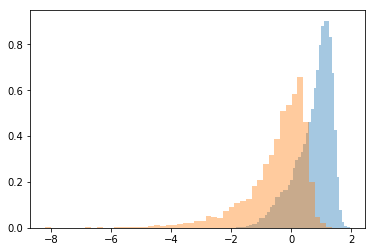

new best: 9.2218556796748
state: [0.31409146112100644, 0.31733395528889796, 0.3055650042442892, 0.31027483901096103, 0.32132386917484007, 0.31931765747539126, 0.313557921801099, 0.32212937413664167, 0.3213114444646386, 0.3209834610605811, 0.3132850179817434, 0.31484246598600724]


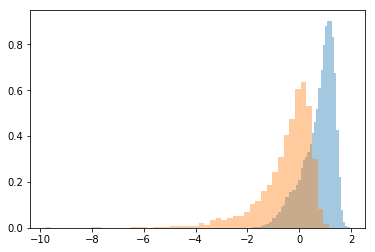

steps: 10 	 loss: 9.28393199325
new best: 9.180632312471603
state: [0.3102997341007318, 0.31519509957298586, 0.3099777783073908, 0.31218504060301966, 0.31766556787339534, 0.3249744096847154, 0.311560764590434, 0.3191942878551635, 0.3205775591750702, 0.3290047538913564, 0.3072506502305071, 0.31395306338393814]


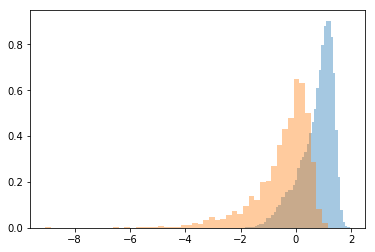

new best: 9.174484353201613
state: [0.3099914085139, 0.3161818496034562, 0.31053670369040476, 0.3125701984195932, 0.3191700604092209, 0.32628058190559706, 0.30978339611382805, 0.3212228064932907, 0.32299872612568886, 0.3326705078428968, 0.3046070797416921, 0.31284196213524296]


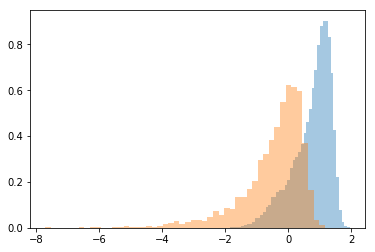

new best: 9.130107592928187
state: [0.3069811989951302, 0.31928828854449354, 0.302374366215856, 0.3045638504763381, 0.3235299259306882, 0.32815060114914096, 0.3121559372407038, 0.3182547011088531, 0.316923997336814, 0.33619992125218573, 0.3057664000373185, 0.3107772955335178]


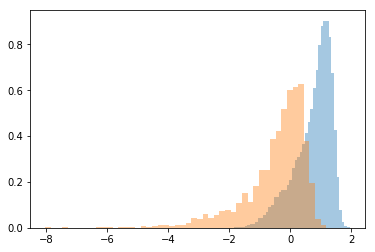

new best: 9.01525993819331
state: [0.3181326495741941, 0.3191253066189684, 0.3007450238069168, 0.31084178888676206, 0.33258110095845655, 0.32492435058908303, 0.3160901578570027, 0.3160765284249692, 0.31599929648562053, 0.33654204369801227, 0.2982595632495212, 0.3038285560907353]


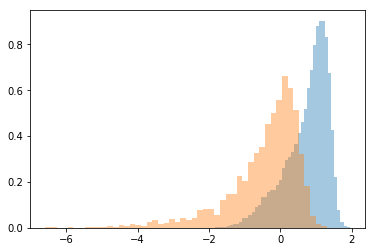

steps: 20 	 loss: 9.01525993819
new best: 8.971382220735753
state: [0.31441653107268247, 0.3201619745727003, 0.301098923070714, 0.31376334877044165, 0.33712110349168606, 0.3219477778101164, 0.31612699173515557, 0.3163154629222165, 0.31927559313420245, 0.34613793388915925, 0.2902522545259335, 0.3044139158518096]


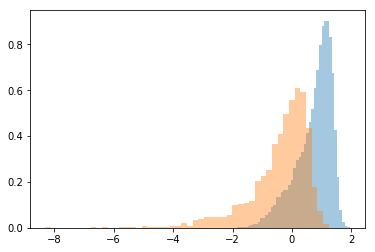

steps: 30 	 loss: 8.98988788618
new best: 8.68284185094176
state: [0.31036671273278066, 0.31646378351186394, 0.3217010582851936, 0.31652767950070687, 0.33870245303394475, 0.31780277680946306, 0.3108576250592301, 0.3089265633231902, 0.31946447253530524, 0.34524174130227203, 0.26929746761998413, 0.3016530293939658]


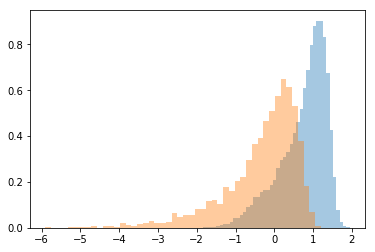

steps: 40 	 loss: 8.8219805133
steps: 50 	 loss: 8.93595421933
steps: 60 	 loss: 8.93171175237
new best: 8.661776606179513
state: [0.29311265085817, 0.3141592249375434, 0.3384091700775065, 0.31984554343142413, 0.3307006562986501, 0.3059351865165649, 0.31942285996179703, 0.3168192375657562, 0.329054067346703, 0.33866979803569197, 0.25200585110490853, 0.3000179825349193]


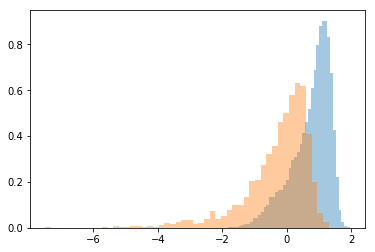

new best: 8.51407086801591
state: [0.2936912958792852, 0.3133098933404308, 0.33912084393358227, 0.31832023902556456, 0.3304735053227063, 0.3070262626547577, 0.31737084172844743, 0.3199532098168372, 0.3291580932449004, 0.33700531450569393, 0.2511672141480101, 0.29887577466592014]


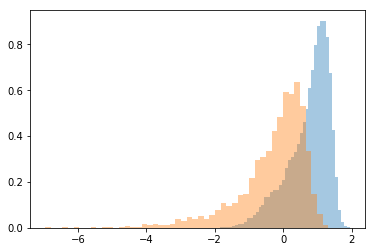

new best: 8.512441931143705
state: [0.2943067103231496, 0.3086113047186252, 0.33746550267886627, 0.31818365429533363, 0.32914862798999417, 0.30747674680573067, 0.3135009342632309, 0.31771830916519833, 0.32916183645947605, 0.33629748626701694, 0.2403971956159736, 0.301599848339204]


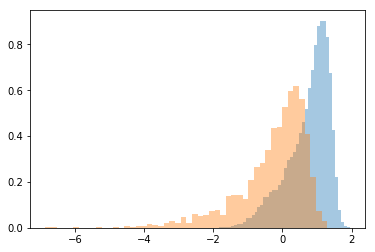

new best: 8.488957451426598
state: [0.29950275515847646, 0.3071351140242722, 0.33761470002625926, 0.3187102705099549, 0.32732743521372504, 0.30848261201349864, 0.31234307293980834, 0.3238502622268586, 0.3277187324843949, 0.33072217518273317, 0.23632568737976548, 0.29663332313312907]


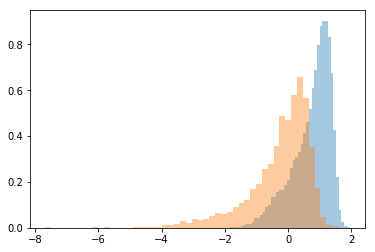

steps: 70 	 loss: 8.48895745143
new best: 8.48870069947425
state: [0.30481630318368574, 0.3043362856071659, 0.3345386063704045, 0.32201570769492377, 0.32567191782835636, 0.3069092391537946, 0.31616224250186675, 0.3241112639616274, 0.32846895371330226, 0.3297322498353533, 0.23738010783808558, 0.29702054836142566]


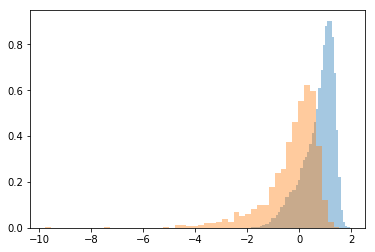

new best: 8.482696042099521
state: [0.3060783992443355, 0.3044965704809678, 0.3356550908658277, 0.32127751907083346, 0.3246297498470072, 0.30672574718524975, 0.31864791206796017, 0.3244952210725185, 0.32747981778979546, 0.3249151457225789, 0.23413346092351556, 0.2980780180783]


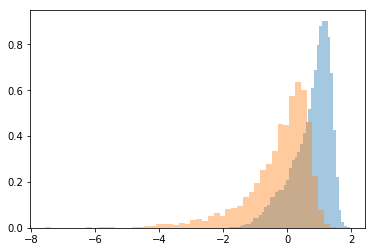

steps: 80 	 loss: 8.49023762275
new best: 8.32630416889622
state: [0.30405503916377324, 0.309258369132831, 0.33428897604409635, 0.3266227143554277, 0.3290032596203526, 0.3063683823850079, 0.3209510885405166, 0.32282151228356476, 0.3254687566190369, 0.3206474294043544, 0.2301056116801251, 0.30525012310111715]


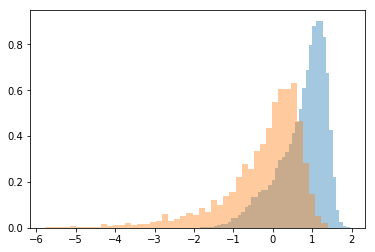

new best: 8.214032415121947
state: [0.3035836795077717, 0.31382399565006436, 0.3429125681425771, 0.32868909154363135, 0.3328462878118844, 0.30138588287340246, 0.3303901051841321, 0.32305707674898926, 0.33179255573866273, 0.3220978479517619, 0.21955221223840865, 0.3055104915909199]


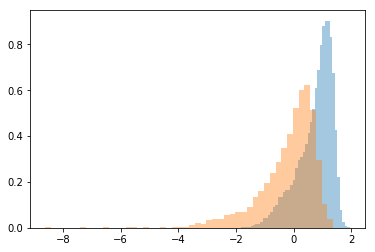

new best: 8.072531386154088
state: [0.3042603799167742, 0.31328206784276985, 0.3426742805038868, 0.3301879938989452, 0.33314949241255165, 0.3042473375218714, 0.3307602690058014, 0.32089517642932075, 0.33422670253510717, 0.32244675028869696, 0.2208420817536938, 0.3042340322043734]


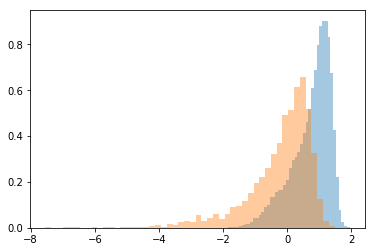

steps: 90 	 loss: 8.22551615293
new best: 8.029940184197093
state: [0.3070025217473083, 0.3167368725982632, 0.33878098599082207, 0.3328600196732427, 0.33688919792489475, 0.30442407698537427, 0.3300889127742212, 0.3233151769125044, 0.33654406815275767, 0.3229899771543473, 0.21642436969077156, 0.304053834581243]


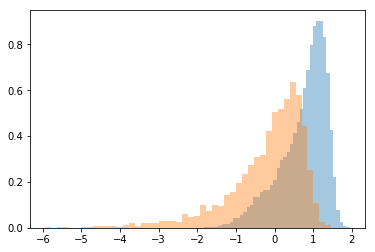

new best: 8.022330565959246
state: [0.31246038629319006, 0.3198040076250326, 0.3360095310002725, 0.33275238605249263, 0.3372345287741706, 0.3073028718984998, 0.32896061402000754, 0.3174673762814552, 0.33538677840385206, 0.3245123546725502, 0.20648358346782864, 0.3033217375525271]


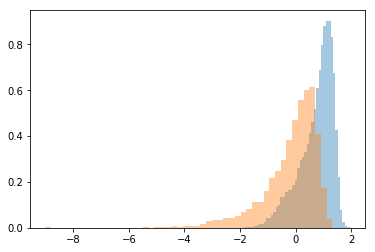

new best: 8.01830813907705
state: [0.3140931554603973, 0.31934968979947154, 0.3361957930524924, 0.33045471794036246, 0.33742502832504584, 0.30577733824508824, 0.32563725377708197, 0.318414492892965, 0.3343327661900477, 0.3250268543714131, 0.20852828638353302, 0.30726912741029366]


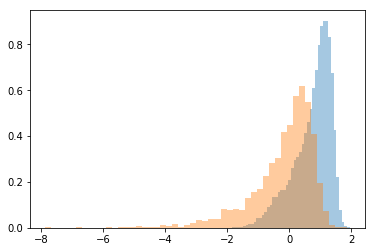

steps: 100 	 loss: 8.06164601266
new best: 7.9171833375358736
state: [0.3142420891627916, 0.3173357381254782, 0.3357965684991957, 0.32626117513287106, 0.33906176197804133, 0.30624968493108723, 0.32603627617968134, 0.3178480784687688, 0.33134290646994896, 0.31872121278709536, 0.20169499137962849, 0.3055772261750523]


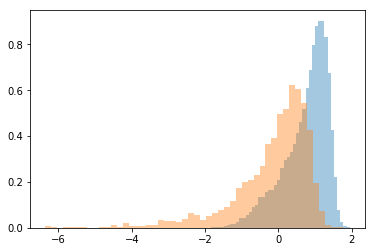

new best: 7.845590985905641
state: [0.31515752554114695, 0.32052455430225224, 0.3362846885477371, 0.32679935426833473, 0.3393358201124555, 0.30774871922680597, 0.32649360189657395, 0.31633345309401245, 0.33024773282443404, 0.31911787514609596, 0.20311050170847658, 0.3052068896468479]


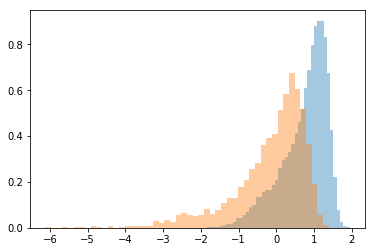

new best: 7.772978430530155
state: [0.3140195749538093, 0.3191176354321811, 0.3347858740609017, 0.324483961228932, 0.33821908406338275, 0.3076221010555427, 0.3242202583540532, 0.31260647784272716, 0.33169205578437, 0.3182871492696426, 0.19940530143059676, 0.30610123790124666]


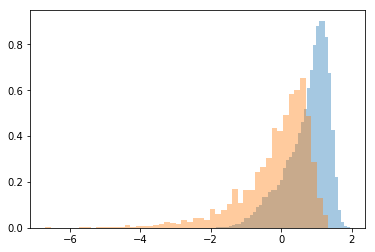

steps: 110 	 loss: 8.12623882358
new best: 7.71842977293122
state: [0.3171349427155861, 0.3155050695188863, 0.3343114260031282, 0.31970649387437616, 0.33870683565220416, 0.3052904917258369, 0.32540728922945783, 0.3146234375380554, 0.3411336962217872, 0.32758884454550746, 0.19818544493368234, 0.3005526120538423]


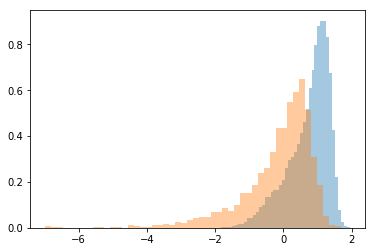

new best: 7.7011406150028785
state: [0.31718901132923033, 0.30982315645727065, 0.3403463456948689, 0.31839057460863157, 0.33720893129510127, 0.30053166423828026, 0.32642277565455924, 0.3154065419545197, 0.3421195905404597, 0.32438143461578783, 0.19790302771688653, 0.2981857374947263]


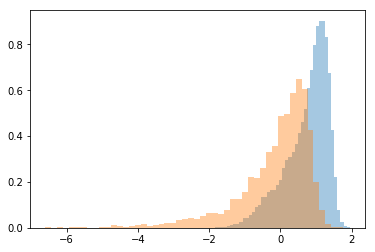

new best: 7.658687647547327
state: [0.3145274240806017, 0.30674121856507297, 0.3450199257800252, 0.31921628788485573, 0.33601359162583705, 0.2933051172867021, 0.3274905250580928, 0.3147897142420521, 0.3414228844201798, 0.3209460265704559, 0.19216688396715567, 0.29881671890251377]


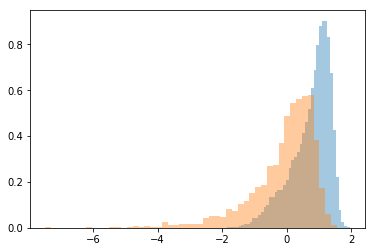

steps: 120 	 loss: 7.65868764755
new best: 7.492396283735511
state: [0.31339406553271176, 0.30632240918164194, 0.34871133667078624, 0.3198203158494882, 0.33214779134797756, 0.2933281414568469, 0.3232999175706157, 0.31259733974749415, 0.34426305560924764, 0.3228847719689263, 0.18787128658973265, 0.2977379875466394]


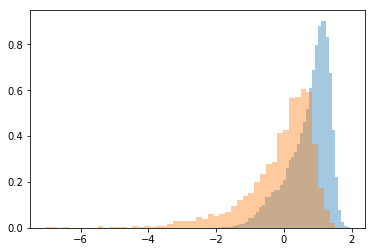

new best: 7.209810803051135
state: [0.321719684054257, 0.3024460908141368, 0.35098158036372085, 0.3220530495072726, 0.33673269853304433, 0.29376911523685484, 0.3262432583304977, 0.3130037070817257, 0.34515699551177004, 0.3142523299993892, 0.18070967343120511, 0.2950299115510968]


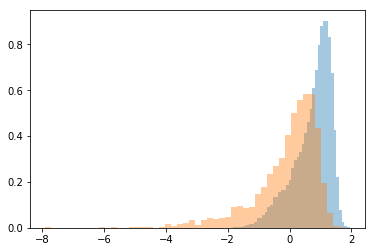

steps: 130 	 loss: 7.57414592726
new best: 7.126018268423615
state: [0.3279380737148237, 0.306178442656509, 0.35091171416852374, 0.3206098067101025, 0.3363867366658534, 0.29218059307166144, 0.32981086545219307, 0.3081063573538115, 0.3472796029084138, 0.30677552222930865, 0.17307939524720348, 0.29933477362090744]


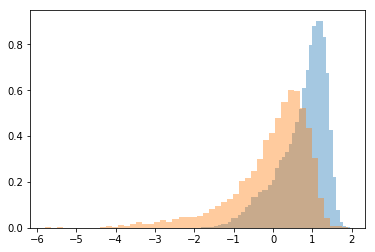

new best: 7.108860653765555
state: [0.33026240664657175, 0.30726633229563577, 0.3474826829394781, 0.31966370923320286, 0.338317263954555, 0.29333325764123236, 0.33632363619015637, 0.30212820025594905, 0.34187977542082215, 0.30758081779071084, 0.17158503240045248, 0.2944175481782615]


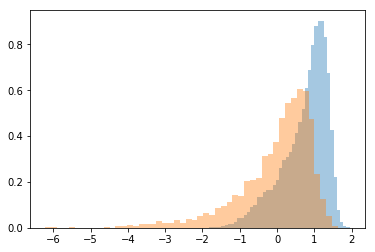

steps: 140 	 loss: 7.36165669883
new best: 7.103640150016193
state: [0.33136155948450147, 0.3085612422540746, 0.34971627144579953, 0.3196751069021819, 0.339058649347992, 0.29661580220215145, 0.3349063516437247, 0.30008718566238285, 0.34044704111840407, 0.31018950660831407, 0.1706278641868932, 0.2962412302609802]


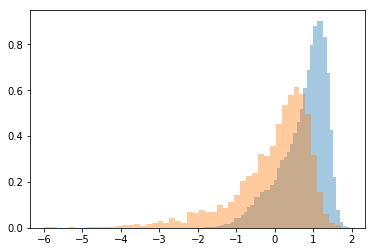

new best: 7.0480549937368435
state: [0.32183097673384536, 0.30813678354585555, 0.34323384429228887, 0.3224578274778329, 0.339903424036089, 0.2936402623130576, 0.34072595038018605, 0.3009173680622033, 0.3431386180411896, 0.3145592393461908, 0.1644771148789273, 0.2953074548633807]


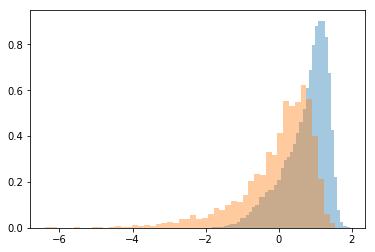

new best: 6.735725532410519
state: [0.32071655861460663, 0.3109062715394367, 0.3429788181139433, 0.32233312712364914, 0.33778213498812687, 0.2977714668533176, 0.3415203400670677, 0.30136029649475293, 0.3430289659015827, 0.3184137552480835, 0.16132877608369417, 0.29230542710853685]


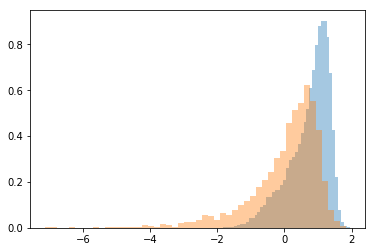

new best: 6.578335954645571
state: [0.3193467139459861, 0.3114795904560229, 0.34187705295931736, 0.32208570206326614, 0.33785343663946127, 0.2960856096619515, 0.34121382638229236, 0.3022668548677253, 0.34511715298779216, 0.3173572491538949, 0.16086935115217585, 0.2915883831992776]


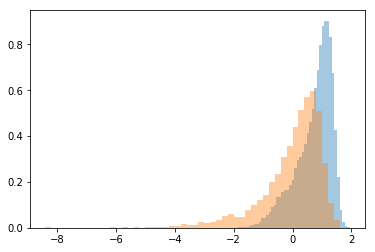

steps: 150 	 loss: 6.63332507988
new best: 6.264338495958634
state: [0.32376126261316673, 0.31257690198625454, 0.33799979296533766, 0.32362224164234527, 0.34726660907476997, 0.2937257977696128, 0.34160588355150073, 0.3027196620541621, 0.3485493413939136, 0.3153110477541705, 0.15214253986807916, 0.2941012966880304]


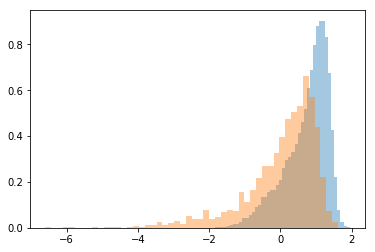

new best: 6.238712176333167
state: [0.3239299420362666, 0.3156807870913994, 0.338157871755058, 0.31892972833914607, 0.3495771969779376, 0.28986494764734716, 0.33712768575615704, 0.2996938149123826, 0.347979285008784, 0.31346166309585627, 0.14966269197503004, 0.29487959733121116]


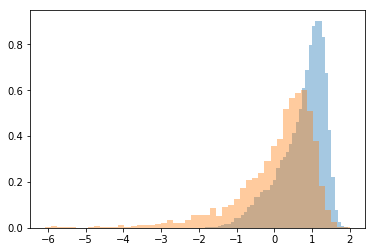

new best: 6.167755755270155
state: [0.3218820881071895, 0.3153809929155908, 0.336945107872002, 0.31987760000995724, 0.3507447743445359, 0.2904739161180224, 0.33859249853673334, 0.30251255273339095, 0.3478738190842084, 0.31461839324087654, 0.1476182993714258, 0.2946371572505844]


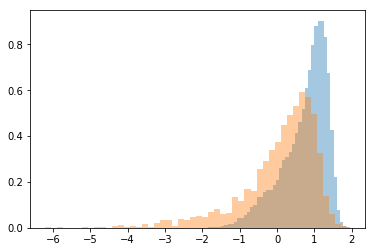

steps: 160 	 loss: 6.45313651671
new best: 5.6816835013965
state: [0.322872622920181, 0.31468909508281495, 0.3306487729928842, 0.3244402536897076, 0.3501722551294006, 0.2883692685664391, 0.33579580186059677, 0.30801665833991176, 0.349461981817548, 0.31363550445595834, 0.14256389972921127, 0.2957080473826406]


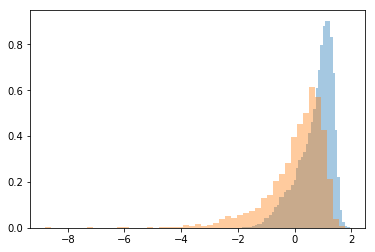

new best: 5.597794490283371
state: [0.32339008095182475, 0.3131660843770098, 0.3326877129778397, 0.3256328589495614, 0.34964380791739397, 0.2872600985778265, 0.3363120951634516, 0.3072754880119254, 0.34793737971308686, 0.31277999561731434, 0.14326704102906557, 0.29547710581238595]


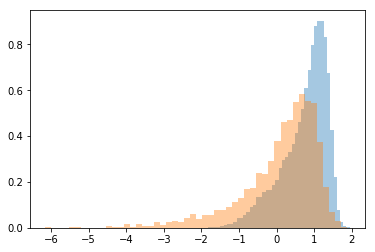

new best: 5.469460915609451
state: [0.32820366936152984, 0.3096931905929502, 0.334806029934145, 0.3320282684097434, 0.35173573055943796, 0.2879284868906939, 0.3390537902957891, 0.3119533713328459, 0.3507730309987202, 0.3144402688342789, 0.1408809836124388, 0.29540459734971924]


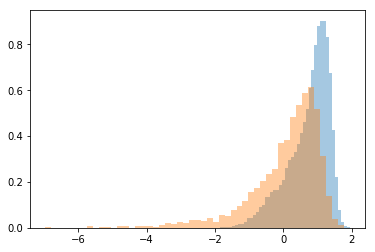

steps: 170 	 loss: 5.70267375635
new best: 5.343669301525558
state: [0.32881126122546417, 0.30829025011481037, 0.335423982313222, 0.3343492050514048, 0.3500186835325212, 0.29648139237418153, 0.34396905083566537, 0.31465358671776594, 0.3554767181235186, 0.3151693185952446, 0.1371398725747178, 0.2981864017522956]


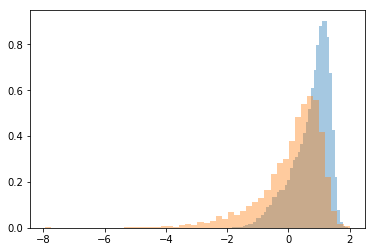

new best: 5.19469513034793
state: [0.33149223783717136, 0.30709772838906263, 0.33575724271899926, 0.33521046599775395, 0.3497592412769676, 0.2955403477615617, 0.3420098127229405, 0.3154312210863976, 0.35613411529193667, 0.3168030888784965, 0.13772803859095098, 0.2979319827019562]


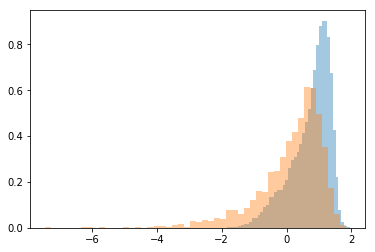

steps: 180 	 loss: 5.37105336652
new best: 4.8196157325326245
state: [0.32932572178052183, 0.3087947645746985, 0.33919811117037024, 0.3343781280175521, 0.35372972985195855, 0.29842552639538517, 0.3400228530307993, 0.32000987262192293, 0.3505616891745191, 0.3141062233144515, 0.12680660177232692, 0.29323067663768154]


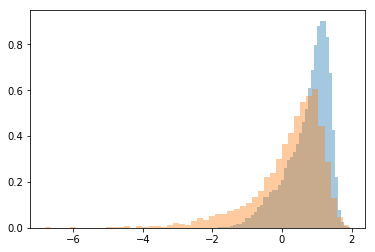

new best: 4.728198786236421
state: [0.32964291611511615, 0.3123466449544516, 0.3380678078160676, 0.33304615389960673, 0.35181807833585654, 0.2996748570174654, 0.3400773022578608, 0.3202978752534013, 0.34976132808076665, 0.3131442009233862, 0.12430461996447661, 0.2932184181543269]


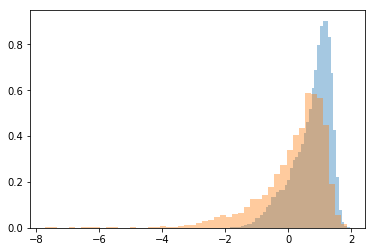

new best: 4.586499701591311
state: [0.3288497824316244, 0.31192199267675813, 0.3372186522387231, 0.3338219674696099, 0.35388108251224754, 0.2987423899330672, 0.33899673947428083, 0.3238769593241547, 0.3489803650422203, 0.3133637482467811, 0.12192282398089756, 0.29374916081720626]


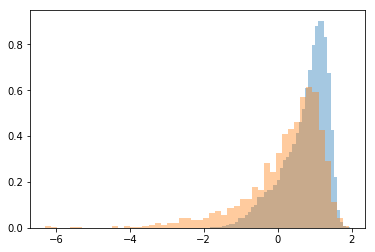

new best: 4.116061488873982
state: [0.32922205760943607, 0.31300326666920414, 0.3394919602189867, 0.3318031772179889, 0.35394624008125053, 0.2983336961622187, 0.33940807554005564, 0.32609047923702916, 0.34867042716765917, 0.31490982906318654, 0.1205092598134597, 0.29333814538850417]


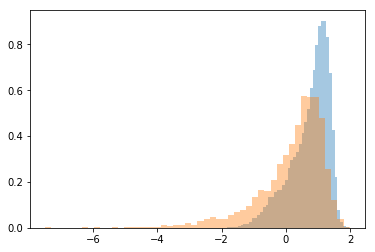

steps: 190 	 loss: 4.20639939248
new best: 3.9722533559237037
state: [0.32810346325098466, 0.3102069544394427, 0.3364057315652407, 0.32718659281412077, 0.35500957846480813, 0.29993365739126854, 0.334402857316141, 0.32902003919752565, 0.34500911001720674, 0.31545152345847294, 0.11295363587180868, 0.28942180450970406]


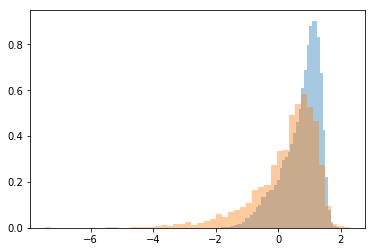

new best: 3.8532466054649595
state: [0.33314612683428413, 0.31301755988098845, 0.333745359426892, 0.32738648890753347, 0.3562916464453762, 0.3042928432587648, 0.3295906276073713, 0.33030708574424705, 0.34806100298719783, 0.31777352991062197, 0.11257416716984685, 0.29146659098423794]


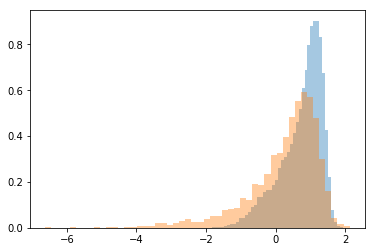

new best: 3.72545294417421
state: [0.3335547764556937, 0.3128562268704446, 0.33170505457167354, 0.33021296796437705, 0.3568074161414152, 0.3049867350334209, 0.33055093538626507, 0.3296404160855361, 0.3457055604132432, 0.3179160803176729, 0.1087369120879724, 0.29055327101241113]


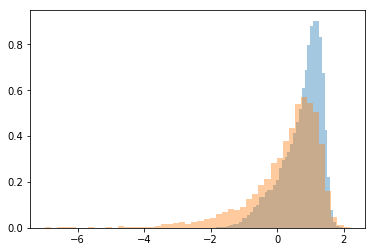

new best: 3.4514190013707533
state: [0.33139161048526633, 0.3126205135140756, 0.33122328208425583, 0.32985934695884356, 0.3563496128816107, 0.3059627420768535, 0.3297090701193331, 0.33118577713901537, 0.3469664712439019, 0.317857001792369, 0.10848014991482634, 0.29164158032817633]


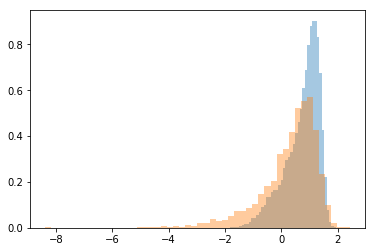

steps: 200 	 loss: 3.74682872544
new best: 3.311241070462013
state: [0.3272868131987312, 0.3173337235955664, 0.3336426849510216, 0.3255470190389113, 0.3563625781969341, 0.3114899451423095, 0.32230735469488164, 0.3311888824541831, 0.34537141502848206, 0.3180003331646087, 0.10500926779114127, 0.2896646641590505]


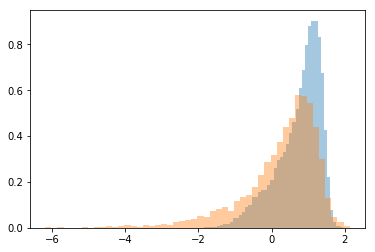

steps: 210 	 loss: 3.70914575423
new best: 2.8919572012152504
state: [0.3328660165240875, 0.3149546634997538, 0.3350801713942301, 0.3265494493834991, 0.35893588559904654, 0.3139789418929616, 0.3199393259129898, 0.3273494055132579, 0.34687656868655725, 0.31674021192703583, 0.10014811755121077, 0.2891791612124787]


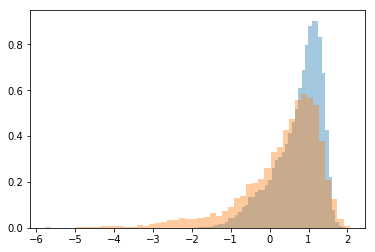

steps: 220 	 loss: 3.41603448296
new best: 2.829771798058823
state: [0.33242479394842717, 0.318417779117916, 0.330013420523629, 0.3273725042652219, 0.3591320156103908, 0.3140213126865929, 0.3195611144785118, 0.3258099155922672, 0.3482626897947564, 0.3154840346515722, 0.0967453844632287, 0.2875151578531616]


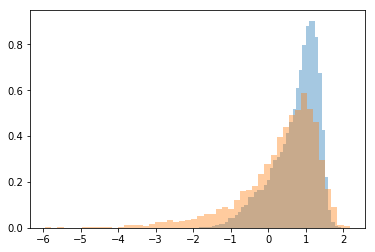

steps: 230 	 loss: 2.82977179806
steps: 240 	 loss: 3.69358791503
steps: 250 	 loss: 3.69830486157
new best: 2.7194304327077257
state: [0.3337105851252581, 0.3201906754166662, 0.3238164339993487, 0.3258035077716222, 0.35613863396927786, 0.3177185418183075, 0.3192888559458971, 0.329655339277771, 0.3416872164985902, 0.3190348490560645, 0.09835700952596023, 0.28732350511177795]


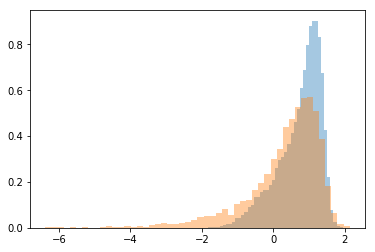

steps: 260 	 loss: 2.71943043271
steps: 270 	 loss: 3.41670557554
new best: 2.712926358320147
state: [0.3389852438032455, 0.32246106045507344, 0.3226598732935762, 0.32797707638741647, 0.35838469292914754, 0.3206165892367749, 0.3144264500959536, 0.32927724737351455, 0.34387736118427015, 0.3172474712391597, 0.09771514770537966, 0.28592929693025054]


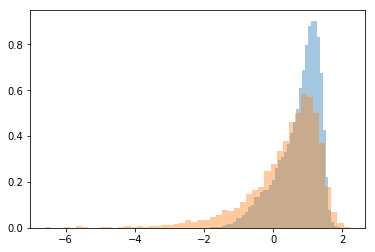

steps: 280 	 loss: 2.8998133132
steps: 290 	 loss: 3.38635673196
steps: 300 	 loss: 3.12204241755
steps: 310 	 loss: 3.05389616754
steps: 320 	 loss: 3.34517608011
steps: 330 	 loss: 4.18322587425
steps: 340 	 loss: 3.33996916335
steps: 350 	 loss: 3.18250635376
steps: 360 	 loss: 3.88779891189
steps: 370 	 loss: 2.98715079354
steps: 380 	 loss: 3.24789716224
steps: 390 	 loss: 3.50118900239
steps: 400 	 loss: 3.48621747007
steps: 410 	 loss: 3.2660520349
steps: 420 	 loss: 3.48422539369
steps: 430 	 loss: 3.47149079947
steps: 440 	 loss: 3.44696145832
steps: 450 	 loss: 3.48161539787
steps: 460 	 loss: 3.66344542082
steps: 470 	 loss: 3.31913609487
steps: 480 	 loss: 3.23033152321
steps: 490 	 loss: 3.50161172241
steps: 500 	 loss: 3.41092327738
steps: 510 	 loss: 3.34073115384
steps: 520 	 loss: 3.00502988332
steps: 530 	 loss: 3.13325128712
steps: 540 	 loss: 3.11393063466
steps: 550 	 loss: 3.56221067008
steps: 560 	 loss: 3.20602725721
steps: 570 	 loss: 3.0039182473
new best: 2.6

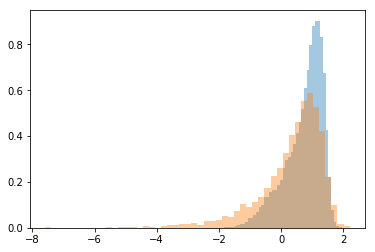

steps: 580 	 loss: 2.67591560157
steps: 590 	 loss: 3.05755147454
steps: 600 	 loss: 2.83993087642
new best: 2.4777416579311997
state: [0.3467250144448724, 0.32549142999946895, 0.3224627687663842, 0.31460104002081996, 0.3423484367768743, 0.3086893238137966, 0.32575616266918367, 0.33838390928574813, 0.34953986785578106, 0.30535442312721417, 0.10057108022549784, 0.2610477499918499]


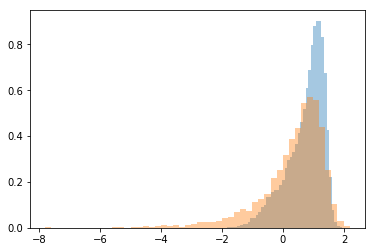

steps: 610 	 loss: 3.13786787433
steps: 620 	 loss: 3.06786367981
new best: 2.4586744495607373
state: [0.35139757988574916, 0.3225897376531013, 0.3231256166645264, 0.31999084857183613, 0.3401455260778522, 0.31050764101354256, 0.32704633418487006, 0.329773903663409, 0.3477634677238127, 0.30698489544615476, 0.1004573217351619, 0.25438127438266717]


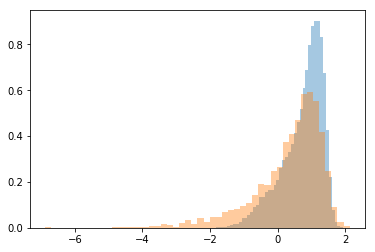

steps: 630 	 loss: 2.64820259689
steps: 640 	 loss: 3.28117613689
steps: 650 	 loss: 3.15600290411
steps: 660 	 loss: 3.20413157699
steps: 670 	 loss: 3.75319722276
steps: 680 	 loss: 3.42813833625
steps: 690 	 loss: 3.28790333765
steps: 700 	 loss: 3.06757023849
steps: 710 	 loss: 3.72152596293
steps: 720 	 loss: 3.5270824355
steps: 730 	 loss: 3.00534304937
steps: 740 	 loss: 3.88828017141
steps: 750 	 loss: 3.42987638574
steps: 760 	 loss: 3.31636822727
steps: 770 	 loss: 3.1351724403
steps: 780 	 loss: 3.14052006136
steps: 790 	 loss: 3.26627525339
steps: 800 	 loss: 3.12731399913
steps: 810 	 loss: 3.06727692131
steps: 820 	 loss: 3.09689097554
steps: 830 	 loss: 3.21748475089
steps: 840 	 loss: 3.19381017174
steps: 850 	 loss: 2.91368471465
steps: 860 	 loss: 3.25102017725
steps: 870 	 loss: 3.15897744744
steps: 880 	 loss: 2.88361310412
steps: 890 	 loss: 3.63570372775
steps: 900 	 loss: 3.57048103007
steps: 910 	 loss: 3.27446425596
steps: 920 	 loss: 2.8991448212
steps: 930 	 

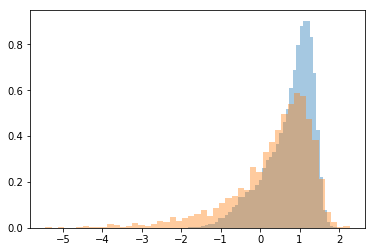

steps: 1340 	 loss: 3.33059576282
steps: 1350 	 loss: 3.40207232788
steps: 1360 	 loss: 3.17173688222
steps: 1370 	 loss: 3.12625255012
steps: 1380 	 loss: 3.1725908322
steps: 1390 	 loss: 3.11160114383
steps: 1400 	 loss: 2.83725681917
steps: 1410 	 loss: 3.56242271649
steps: 1420 	 loss: 2.93968292454
steps: 1430 	 loss: 3.38918498165
steps: 1440 	 loss: 3.32133929968
steps: 1450 	 loss: 2.98067891886
steps: 1460 	 loss: 3.4712673209
steps: 1470 	 loss: 3.55438337531
steps: 1480 	 loss: 3.15457229953
steps: 1490 	 loss: 3.20598230184
steps: 1500 	 loss: 3.1309075318
steps: 1510 	 loss: 3.12814978792
steps: 1520 	 loss: 2.68269782259
steps: 1530 	 loss: 3.10830758598
steps: 1540 	 loss: 3.05010060912
steps: 1550 	 loss: 2.72685704957
steps: 1560 	 loss: 3.08661043554
steps: 1570 	 loss: 3.06311594875
steps: 1580 	 loss: 3.08613742868
steps: 1590 	 loss: 3.02792753897
steps: 1600 	 loss: 2.96093872733
steps: 1610 	 loss: 3.04767285415
steps: 1620 	 loss: 3.25978643863
steps: 1630 	 los

steps: 3760 	 loss: 2.38240199686
steps: 3770 	 loss: 3.29429310075
steps: 3780 	 loss: 3.24451823382
steps: 3790 	 loss: 3.00210800876
steps: 3800 	 loss: 3.25506177354
steps: 3810 	 loss: 2.92375055113
steps: 3820 	 loss: 2.78748957743
steps: 3830 	 loss: 3.109509825
steps: 3840 	 loss: 2.66130257554
steps: 3850 	 loss: 2.82220533137
steps: 3860 	 loss: 3.1018005001
steps: 3870 	 loss: 2.84662564955
steps: 3880 	 loss: 3.13323140238
steps: 3890 	 loss: 3.05601067258
steps: 3900 	 loss: 2.62920441655
steps: 3910 	 loss: 2.87439107736
steps: 3920 	 loss: 2.93405613813
steps: 3930 	 loss: 3.24738609456
steps: 3940 	 loss: 2.72426463779
steps: 3950 	 loss: 2.9965401494
steps: 3960 	 loss: 3.08731718088
steps: 3970 	 loss: 2.45507066295
steps: 3980 	 loss: 2.92386206234
steps: 3990 	 loss: 2.97157946923
steps: 4000 	 loss: 2.93890941634
steps: 4010 	 loss: 3.09103352089
steps: 4020 	 loss: 3.24332647891
steps: 4030 	 loss: 3.11972939807
steps: 4040 	 loss: 3.18823445476
steps: 4050 	 loss

KeyboardInterrupt: 

In [6]:
gradient_descent(initial_vars(10), num_iter=10000, gradwidth=.01, lr=.0001, real_eigs = CY_eigs[10]) 

new best: 2.8839966971750317
state: [0.31622776721815943, 0.31622777035593336, 0.3162277655242171, 0.3162277648340004, 0.3162277674234374, 0.31622776285381476, 0.3162277639556205, 0.31622776709449596, 0.31622777164024757, 0.31622776159200416, 0.31622776800247127, 0.3162277650657971, 0.3162277666976053, 0.31622776640903155, 0.31622776238198846, 0.3162277699426496, 0.3162277669686482, 0.3162277671414797, 0.31622776797753377, 0.3162277670455204, 0.3162277668789391, 0.3162277724424676, 0.31622776857744, 0.31622776355607213, 0.3162277682467365, 0.3162277680753337, 0.31622776546864706, 0.3162277630439512, 0.3162277691680478, 0.3162277640289411, 0.3162277639603386, 0.31622776884661147, 0.3162277677951016, 0.31622776781014855, 0.3162277659618528, 0.31622776468215696, 0.316227768075805, 0.31622776340968084, 0.3162277634034289, 0.31622776507994327, 0.31622776413938103, 0.3162277664457135, 0.3162277713780417, 0.316227769920396, 0.31622776645747347, 0.31622776817534515, 0.31622776749982046, 0.3162

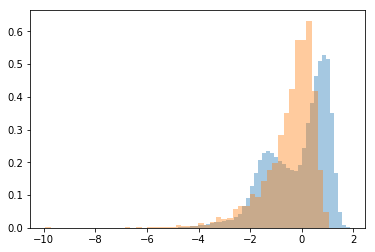

steps: 0 	 loss: 2.88399669718
new best: 2.847104145571697
state: [0.31576105141675725, 0.31696020951921083, 0.3164897225939078, 0.3162601768224726, 0.3168879704413993, 0.3164287416601556, 0.31633355417476305, 0.31644646575839236, 0.3160392914151182, 0.3169320930943516, 0.31712871565802936, 0.31584062467476354, 0.3163585718807434, 0.31568894062876673, 0.31592558067272225, 0.31627748293800967, 0.31637827066938495, 0.31604754135807506, 0.3162717394318898, 0.3160650589275544, 0.3160463889333147, 0.3165696080506271, 0.3160820453241459, 0.31584215751745714, 0.3160967759756462, 0.31599118274071775, 0.3164353587045771, 0.3163015587569323, 0.31674192415749003, 0.31614130956587605, 0.3163147397916935, 0.3158270703895319, 0.316553375795219, 0.3157376581793456, 0.31650663919762967, 0.3164707197534932, 0.3160315028761803, 0.31604887755204847, 0.3161012116645605, 0.3159327880415526, 0.316457970646541, 0.31620535383046877, 0.31587863217321965, 0.31600775559482, 0.31626989843097925, 0.315973373910863

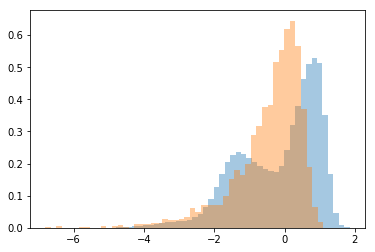

new best: 2.7155666535942538
state: [0.3160101132908998, 0.3171281891426945, 0.31621278870256, 0.31565928749504174, 0.31649150615341576, 0.3163494892655524, 0.3158751018706433, 0.3170268948442694, 0.3159374322105046, 0.31696744437453794, 0.3166865480951647, 0.3159892642181805, 0.3161200086964939, 0.3158892218396975, 0.3151897188126298, 0.31673839957836075, 0.3171237847244255, 0.31635461398557846, 0.3166202762003505, 0.31621952746651566, 0.31555960773061403, 0.3167257923001924, 0.3162682128518982, 0.3158508522606911, 0.31626603685404686, 0.31633993485148465, 0.31725069689622853, 0.31624492081281425, 0.31673333720843944, 0.31627861725260537, 0.3165695277343047, 0.3161272565876929, 0.31684919622343494, 0.31566343165881006, 0.3165970081435644, 0.31651080804413423, 0.3147979429109749, 0.3167950226459081, 0.3156811042917504, 0.3156066599870696, 0.31670988301872366, 0.3164899164607569, 0.31643016237371785, 0.31556266693225826, 0.31613552394797884, 0.31588842146331647, 0.3161241189793278, 0.31

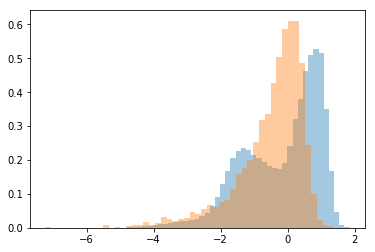

steps: 10 	 loss: 2.96427434506
new best: 2.6328847963857185
state: [0.31645406209674604, 0.31883437452964997, 0.3169773982749075, 0.3162815790587531, 0.3192535467735597, 0.315405632890389, 0.31479330819107626, 0.3154391870774354, 0.3152126741589314, 0.3154695246554119, 0.316494159510015, 0.3141497926790891, 0.3163949256828009, 0.314822293001082, 0.31486242820705085, 0.3169511778293222, 0.31655284899082253, 0.31821544796788304, 0.3154834623431336, 0.31562182370054864, 0.31496846853442084, 0.3150946197921271, 0.3155738200083002, 0.31618382914371473, 0.31428967339772196, 0.3174945590645881, 0.31565275525218706, 0.3193537502940477, 0.31765667079066, 0.3158825532752033, 0.31645677182262444, 0.3168325970873231, 0.3148625096047412, 0.315316657083514, 0.31680140885617414, 0.31613714546561394, 0.3149359613839989, 0.3153715697558057, 0.31551889559547164, 0.31470513992283844, 0.3161083760644201, 0.3183212842296878, 0.31578405304254553, 0.31591665825715753, 0.31480362646139054, 0.3156485439178883

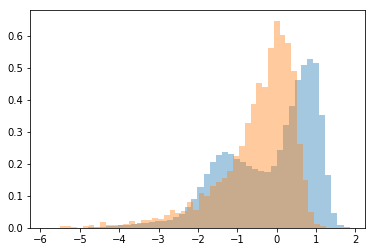

steps: 20 	 loss: 2.79005529594
new best: 2.5435532252613675
state: [0.3157591046886385, 0.31902744309424874, 0.3164729449604133, 0.31722819088590615, 0.3181063493819035, 0.3175359620576042, 0.3154738927992631, 0.3161733113703459, 0.3166681177198196, 0.31614076398597935, 0.3165409354821112, 0.31206367719826733, 0.314528771651192, 0.3157923229553858, 0.3166650612248157, 0.31382205279191056, 0.31660256524440167, 0.31986938447602303, 0.31577570462660404, 0.31424023673077894, 0.31630328238683886, 0.31409740355775295, 0.3180629961064884, 0.317834968153723, 0.31332975732130186, 0.3168511819269689, 0.3151710070190452, 0.3184370155191986, 0.3172412520651015, 0.31604918462404935, 0.3158572269308865, 0.316520352839718, 0.3133652558591661, 0.3163595887925317, 0.31715769857324155, 0.3156528006401944, 0.3146913684425661, 0.3153752432835074, 0.3152045481095254, 0.31342171908129435, 0.31583516346076207, 0.31755559803839595, 0.3155505029032619, 0.31179111998762726, 0.315977750067116, 0.314158224119181

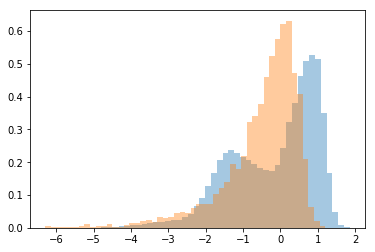

steps: 30 	 loss: 2.95570392337
steps: 40 	 loss: 2.90872669515
steps: 50 	 loss: 2.98552107195
steps: 60 	 loss: 2.96616787189
steps: 70 	 loss: 2.85024863473
steps: 80 	 loss: 2.86314612121
steps: 90 	 loss: 2.78473265984
steps: 100 	 loss: 2.77701116456
steps: 110 	 loss: 2.72098462642
steps: 120 	 loss: 2.90988619757
steps: 130 	 loss: 2.66457190744
steps: 140 	 loss: 2.7559799402
new best: 2.4864717779726258
state: [0.3105939915840857, 0.3174508245766395, 0.3133564704494125, 0.3194838464794115, 0.3282720600294192, 0.3205863081005742, 0.31733879500417944, 0.3215698686919195, 0.31064836552903935, 0.31697598399592364, 0.3151451902953587, 0.3111348230066969, 0.31504242298644897, 0.31844787526242563, 0.3195996006804541, 0.31678372870721877, 0.3140313398593455, 0.32493501342798864, 0.31535650037846197, 0.31331837052688216, 0.3137039329401653, 0.31439554343481807, 0.31985332732924354, 0.31526566719381155, 0.3173263595731443, 0.31429714199296066, 0.3177570176722338, 0.3239853790476106, 0.

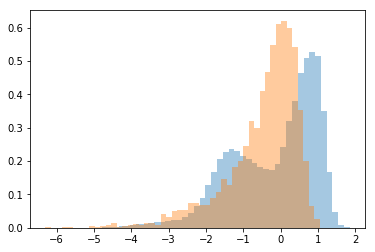

steps: 150 	 loss: 2.8910402762
steps: 160 	 loss: 2.81449856208
steps: 170 	 loss: 2.89190227481
steps: 180 	 loss: 2.91053768528
steps: 190 	 loss: 2.53542910083
steps: 200 	 loss: 2.6510969657
steps: 210 	 loss: 2.93502743581
steps: 220 	 loss: 2.81635626568
steps: 230 	 loss: 2.66282434206
steps: 240 	 loss: 2.63350082052
steps: 250 	 loss: 2.88585228185
steps: 260 	 loss: 2.71018960394
steps: 270 	 loss: 2.86738180519
steps: 280 	 loss: 2.90165599908
steps: 290 	 loss: 2.773075153
steps: 300 	 loss: 2.56935448838
steps: 310 	 loss: 2.78856740689
steps: 320 	 loss: 2.68114360569
steps: 330 	 loss: 2.93874465414
steps: 340 	 loss: 2.84425386277
steps: 350 	 loss: 2.91028649657
steps: 360 	 loss: 2.59064073536
steps: 370 	 loss: 2.94683590554
steps: 380 	 loss: 2.84867976529
steps: 390 	 loss: 2.93119276893
steps: 400 	 loss: 2.64327764184
steps: 410 	 loss: 2.92505150527
steps: 420 	 loss: 2.82429711956
steps: 430 	 loss: 2.88342143457
steps: 440 	 loss: 2.86623450943
steps: 450 	 l

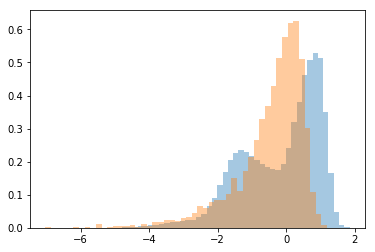

steps: 600 	 loss: 2.76124681733
steps: 610 	 loss: 2.91892334512
steps: 620 	 loss: 2.826534606
steps: 630 	 loss: 2.83660058833
steps: 640 	 loss: 2.87689560906
steps: 650 	 loss: 2.67486100831
steps: 660 	 loss: 2.57315375568
steps: 670 	 loss: 2.73263499283
new best: 2.2562787213010145
state: [0.3113005845312803, 0.33068048065965167, 0.3189801692684277, 0.3261275187576037, 0.32883481443725293, 0.34336970219120777, 0.3202337814765954, 0.33054160068643745, 0.3168706910202958, 0.33310868047398107, 0.3045450750526841, 0.29627471812776995, 0.30188323754564944, 0.3360241155388819, 0.32188246759865546, 0.3048113640239263, 0.31200730455989806, 0.3304525417965899, 0.3036867263808781, 0.3108466923558696, 0.3140925144603983, 0.30635818912130786, 0.3151431999875239, 0.3044760115998866, 0.3195898223617726, 0.32233964026859546, 0.32283792535070344, 0.3330237858836405, 0.2959754925910718, 0.31719645085844916, 0.328986475757717, 0.3125152794601715, 0.31212078521261793, 0.29878285104984936, 0.31983

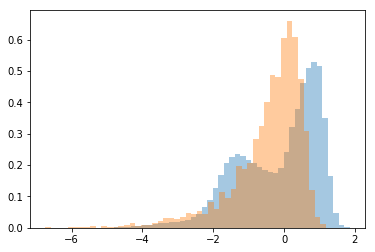

steps: 680 	 loss: 2.88545224582
steps: 690 	 loss: 2.81371609197
steps: 700 	 loss: 2.71777153036
steps: 710 	 loss: 2.63558797017
steps: 720 	 loss: 2.79276913464
steps: 730 	 loss: 2.81683963324
steps: 740 	 loss: 2.82502220966
steps: 750 	 loss: 2.98065806131
steps: 760 	 loss: 2.70208467716
steps: 770 	 loss: 2.69209636477
steps: 780 	 loss: 2.772521267
steps: 790 	 loss: 2.59048865548
steps: 800 	 loss: 2.82842618704
steps: 810 	 loss: 2.76149615467
steps: 820 	 loss: 2.46980789055
steps: 830 	 loss: 2.71639945736
steps: 840 	 loss: 2.69686822767
steps: 850 	 loss: 2.6302059384
steps: 860 	 loss: 2.8620669345
steps: 870 	 loss: 2.62775304156
steps: 880 	 loss: 2.69273490798
steps: 890 	 loss: 2.86184418847
steps: 900 	 loss: 2.58534639999
steps: 910 	 loss: 2.70405145937
steps: 920 	 loss: 2.67093874635
steps: 930 	 loss: 2.76785480009
steps: 940 	 loss: 2.76002742781
steps: 950 	 loss: 2.79414568513
steps: 960 	 loss: 2.81124770299
steps: 970 	 loss: 2.81965907115
steps: 980 	 l

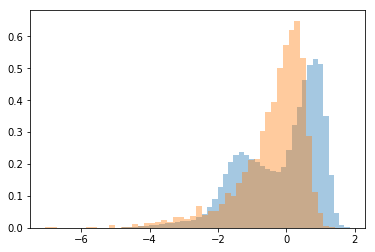

steps: 1420 	 loss: 2.63037261954
steps: 1430 	 loss: 2.66714710514
steps: 1440 	 loss: 2.82387365965
steps: 1450 	 loss: 2.5482409583
steps: 1460 	 loss: 2.63991601034
steps: 1470 	 loss: 2.64740520829
steps: 1480 	 loss: 2.63896996586
steps: 1490 	 loss: 2.60285696526
steps: 1500 	 loss: 2.71195659774
steps: 1510 	 loss: 2.65831337091
new best: 2.1731973568095135
state: [0.2971181576832126, 0.3245920813547797, 0.3180565996367685, 0.3158992215975745, 0.32898890390772917, 0.32538684713442784, 0.32017547773240135, 0.35241902805424336, 0.3109232921364144, 0.3269931032198173, 0.29002391493123897, 0.2835493495986369, 0.31670174625076225, 0.34781217796179403, 0.3356636869707309, 0.3007270695629715, 0.3417661054196566, 0.32859949332202965, 0.323676774458305, 0.3129781216734813, 0.3233273595561194, 0.2893521395210441, 0.2988934544026003, 0.30944653052849064, 0.3184501342106029, 0.32943165234045496, 0.2998058013241003, 0.3199834311066603, 0.30871309616225784, 0.33284228963781143, 0.34286957888

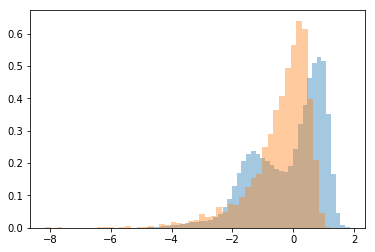

steps: 1520 	 loss: 2.76310274472
steps: 1530 	 loss: 2.72573974674
steps: 1540 	 loss: 2.79413692383
steps: 1550 	 loss: 2.43009057951
steps: 1560 	 loss: 2.54015435789
steps: 1570 	 loss: 2.47048789849
steps: 1580 	 loss: 2.6432868813
steps: 1590 	 loss: 2.5666523896
steps: 1600 	 loss: 2.67531450859


KeyboardInterrupt: 

In [4]:
gradient_descent(initial_vars(10), num_iter=5000, gradwidth=.01, lr=.0001, real_eigs = CY_eigs[50]) 